# CSD 7: Deep Learning for Image Classification

0. For this Case Study assignment you should have in your current folder the ebay_boys_girls_shirts folder, holding the four CSV files describing the train and test shirts images, and the boys and girls images folders. This is what we did in CSD 1, **if you already have the data in your current folder you don't need to run this again!**:

In [ ]:
import requests
import tarfile

url = "http://www.tau.ac.il/~saharon/DScourse/ebay_boys_girls_shirts.tar.gz"
r = requests.get(url)

with open("ebay_boys_girls_shirts.tar", "wb") as file:
    file.write(r.content)

with tarfile.open("ebay_boys_girls_shirts.tar") as tar:
    tar.extractall('.')

1. In this Case Study assignment we again try to classify an unseen shirt image as being of "boys" or of "girls". Yet this time we will be using heavier machinery: Deep Learning. Specifically we're going to get good results using Convolutional Neural Networks.

    But first, load all matrices with the help of the functions composed so far:

In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = transform.resize(img, (w, h), mode='constant')
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images, files_list

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def numpy_array_size_in_bytes(a):
    return a.size * a.itemsize

def shape_and_size(x, name):
    n_rows = x.shape[0]
    if len(x.shape) == 1:
        n_cols = 1
    elif len(x.shape) == 2:
        n_cols = x.shape[1]
    else:
        warnings.warn('Function is meaningful for 1 or 2-D numpy arrays, taking 2nd dimension as n_cols')
        n_cols = x.shape[1]        
    size = numpy_array_size_in_bytes(x)
    print('%s Shape: %d X %d, Size (bytes): %d' % (name, n_rows, n_cols, size))

def conf_matrix(y_true, y_pred):
    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

def get_final_matrices(n_train = None, n_test = None):
    folder = 'ebay_boys_girls_shirts/'
    x_boys_train, boys_train_files = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
    x_boys_test, boys_test_files = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)
    x_girls_train, girls_train_files = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
    x_girls_test, girls_test_files = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([np.uint8(0)] * x_boys_train.shape[0])
    y_boys_test = np.array([np.uint8(0)] * x_boys_test.shape[0])
    y_girls_train = np.array([np.uint8(1)] * x_girls_train.shape[0])
    y_girls_test = np.array([np.uint8(1)] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

In [2]:
x_train, x_test, y_train, y_test = get_final_matrices()

shape_and_size(x_train, 'x_train')
shape_and_size(x_test, 'x_test')
shape_and_size(y_train, 'y_train')
shape_and_size(y_test, 'y_test')

x_train Shape: 20000 X 30000, Size (bytes): 600000000
x_test Shape: 5000 X 30000, Size (bytes): 150000000
y_train Shape: 20000 X 1, Size (bytes): 160000
y_test Shape: 5000 X 1, Size (bytes): 40000


Our platform of choice [Keras](https://keras.io/) accepts `x_train` of type `float`. It's best to turn it to float in the 0-1 range, the size should still be OK (or you'll need to add more memory to your Docker/Azure machine):

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

2. We'll start with a "simple" neural network with a few hidden (`Dense`) layers, a.k.a a Multi-Layered Perceptron.

    We'll use a standard batch size of 128, for 10 epochs, a RELU and Dropout between layers. Since we're looking for a single 0-1 probability-like score to classify a shirt image as of "boys" or of "girls" we'll use the `sigmoid` activation function.

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 128
epochs = 10

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(30000,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               15360512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
__________

Here our optimizer method of choice will be [`adam`](https://keras.io/optimizers/#adam) and the loss function [`binary_crossentropy`](https://keras.io/backend/#binary_crossentropy). This is how we `compile` the model:

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

And this is the actual `fit`ting of the model on `x_train` and `y_train`, having `x_test` and `y_test` as validation data (as always, best put here a dataset *different* than the absolutely final test dataset).

**WARNING**: This is the part which takes long time, depending on hardware.

In [6]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/step - loss: 1.1374 - acc: 0.5085 - val_loss: 0.6943 - val_acc: 0.4798
Epoch 2/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.7043 - acc: 0.5109 - val_loss: 0.6801 - val_acc: 0.6394
Epoch 3/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.6781 - acc: 0.5636 - val_loss: 0.6508 - val_acc: 0.6366
Epoch 4/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.6457 - acc: 0.6250 - val_loss: 0.6017 - val_acc: 0.6824
Epoch 5/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.6259 - acc: 0.6473 - val_loss: 0.5905 - val_acc: 0.6800
Epoch 6/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.6119 - acc: 0.6632 - val_loss: 0.5642 - val_acc: 0.7158
Epoch 7/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.6011 - acc: 0.6814 - val_loss: 0.6098 - val_acc:

We reached a not so impressive accuracy of ~73%. If we kept `history` we can plot the model's performance through the different epochs and we can guesstimate if there's any point in having more epochs.

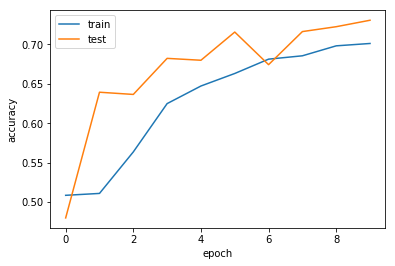

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

3. And now for Convolutional Neural Networks.

    Here Keras needs the original 4D shape of the images array, so we `reshape` them to be of dimensions [N images X Height X Width X N channels].
    We're using a `Conv2D` layer of 32 units and a 3x3 kernel, then a 64 units layer, followed by a `MaxPooling2D` layer and a 25% `Dropout`. The output is then `Flatten`ed and connected to a `Dense` layer of 128 neurons, another 50% `Dropout` and then a single neuron with a `sigmoid` activation function.

In [9]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

img_rows, img_cols, channels = 100, 100, 3

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, channels)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               18874496  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 218s 11ms/step - loss: 0.6113 - acc: 0.6955 - val_loss: 0.4810 - val_acc: 0.7832
Epoch 2/10
20000/20000 [==============================] - 230s 12ms/step - loss: 0.4508 - acc: 0.7893 - val_loss: 0.4404 - val_acc: 0.7842
Epoch 3/10
20000/20000 [==============================] - 232s 12ms/step - loss: 0.3752 - acc: 0.8303 - val_loss: 0.3916 - val_acc: 0.8174
Epoch 4/10
20000/20000 [==============================] - 241s 12ms/step - loss: 0.3037 - acc: 0.8698 - val_loss: 0.3925 - val_acc: 0.8294
Epoch 5/10
20000/20000 [==============================] - 237s 12ms/step - loss: 0.2448 - acc: 0.9005 - val_loss: 0.4054 - val_acc: 0.8314
Epoch 6/10
20000/20000 [==============================] - 232s 12ms/step - loss: 0.1948 - acc: 0.9225 - val_loss: 0.4368 - val_acc: 0.8350
Epoch 7/10
20000/20000 [==============================] - 230s 12ms/step - loss: 0.1486 - acc: 0.9459 - val_loss: 0.4

We got a test accuracy of ~84%, which is a great improvement to what we were able to achieve before.

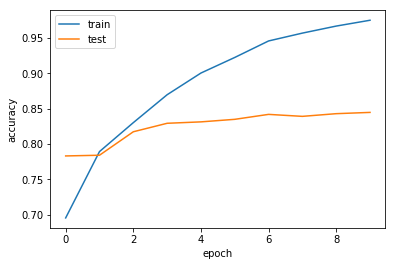

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

4. Your job in this assignment is to simply do better. You must use **only** the images. Notice you have many parameters to tune and also have a look at [`EarlyStopping`](https://keras.io/callbacks/#earlystopping) callback.

In [12]:
### YOUR CODE HERE ###